# SI 618 - Homework 9 - Classification of Employee Attrition

## Objectives
* Be able to extract, transform, and select multiple features to prepare for classification algorithm
* Be able to apply random forest regression
* Be able to evaluate classification results using appropriate metrics

## Please fill in...
### * Your name: Raphael Ku
### * People you worked with:  I worked by myself

## Submission Instructions:
Please submit your completed Databricks notebook file in .html format as well as the URL to the published version of your notebook via Canvas.

## Goal: 
1. Try to predict the IBM employee attrition using multiple factors, and evaluate how good your predictions are; 
2. Find out the leading drivers of Employee Attrition.

The dataset is downloaded from IBM's website:
https://www.ibm.com/communities/analytics/watson-analytics-blog/guide-to-sample-datasets/

#### NOTE: This homework assignment follows very closely the structure of this week's lab assignment.

You should be able to complete the core (i.e. everything other than "Above and Beyond") of this
assignment based on the code in the lab notebook.

#### Read the dataset from AWS S3 bucket.

In [4]:
ACCESS_KEY = ""
SECRET_KEY = ""
ENCODED_SECRET_KEY = SECRET_KEY.replace("/", "%2F")
AWS_BUCKET_NAME = ""
MOUNT_NAME = ""
try:
  dbutils.fs.unmount("/mnt/%s/" % MOUNT_NAME)
except:
  print("Could not unmount %s, but that's ok." % MOUNT_NAME)
dbutils.fs.mount("s3a://%s:%s@%s" % (ACCESS_KEY, ENCODED_SECRET_KEY, AWS_BUCKET_NAME), "/mnt/%s" % MOUNT_NAME)
display(dbutils.fs.ls("/mnt/umsi-data-science/si618wn2017"))

path,name,size
dbfs:/mnt/umsi-data-science/si618wn2017/WA_Fn-UseC_-HR-Employee-Attrition.csv,WA_Fn-UseC_-HR-Employee-Attrition.csv,227977
dbfs:/mnt/umsi-data-science/si618wn2017/bob_ross.csv,bob_ross.csv,66316
dbfs:/mnt/umsi-data-science/si618wn2017/emails.csv,emails.csv,1426122219
dbfs:/mnt/umsi-data-science/si618wn2017/grimmlines.txt,grimmlines.txt,549482
dbfs:/mnt/umsi-data-science/si618wn2017/images/,images/,0
dbfs:/mnt/umsi-data-science/si618wn2017/mail.parquet,mail.parquet,554902149
dbfs:/mnt/umsi-data-science/si618wn2017/spam.csv,spam.csv,698340
dbfs:/mnt/umsi-data-science/si618wn2017/spam_variable_name.csv,spam_variable_name.csv,1385


In [5]:
ibm = spark.read.csv("/mnt/umsi-data-science/si618wn2017/WA_Fn-UseC_-HR-Employee-Attrition.csv", inferSchema=True, header=True)

#### Print the schema of the the dataset

In [7]:
ibm.printSchema()

root
-- Age: integer (nullable = true)
-- Attrition: string (nullable = true)
-- BusinessTravel: string (nullable = true)
-- DailyRate: integer (nullable = true)
-- Department: string (nullable = true)
-- DistanceFromHome: integer (nullable = true)
-- Education: integer (nullable = true)
-- EducationField: string (nullable = true)
-- EmployeeCount: integer (nullable = true)
-- EmployeeNumber: integer (nullable = true)
-- EnvironmentSatisfaction: integer (nullable = true)
-- Gender: string (nullable = true)
-- HourlyRate: integer (nullable = true)
-- JobInvolvement: integer (nullable = true)
-- JobLevel: integer (nullable = true)
-- JobRole: string (nullable = true)
-- JobSatisfaction: integer (nullable = true)
-- MaritalStatus: string (nullable = true)
-- MonthlyIncome: integer (nullable = true)
-- MonthlyRate: integer (nullable = true)
-- NumCompaniesWorked: integer (nullable = true)
-- Over18: string (nullable = true)
-- OverTime: string (nullable = true)
-- PercentSalaryHike: integer (nullable = true)
-- PerformanceRating: integer (nullable = true)
-- RelationshipSatisfaction: integer (nullable = true)
-- StandardHours: integer (nullable = true)
-- StockOptionLevel: integer (nullable = true)
-- TotalWorkingYears: integer (nullable = true)
-- TrainingTimesLastYear: integer (nullable = true)
-- WorkLifeBalance: integer (nullable = true)
-- YearsAtCompany: integer (nullable = true)
-- YearsInCurrentRole: integer (nullable = true)
-- YearsSinceLastPromotion: integer (nullable = true)
-- YearsWithCurrManager: integer (nullable = true)

## Data Description (for some of the variables)

Reference: https://www.kaggle.com/pavansubhasht/ibm-hr-analytics-attrition-dataset


|Feature|Description|
|--|--|
|Education|1: Below College 2: College 3: Bachelor 4: Master 5: Doctor|
|EnvironmentSatisfaction|1: Low 2: Medium 3: High 4: Very High|
|JobInvolvement|1: Low 2: Medium 3: High 4: Very High|
|JobSatisfaction|1: Low 2: Medium 3: High 4: Very High|
|PerformanceRating |1: Low 2: Good 3: Excellent 4: Outstanding|
|RelationshipSatisfaction|1: Low 2: Medium 3: High 4: Very High|
|WorkLifeBalance |1: Bad 2: Good 3: Better 4: Best|

#### Show some of the employee records.

In [10]:
display(ibm)

Age,Attrition,BusinessTravel,DailyRate,Department,DistanceFromHome,Education,EducationField,EmployeeCount,EmployeeNumber,EnvironmentSatisfaction,Gender,HourlyRate,JobInvolvement,JobLevel,JobRole,JobSatisfaction,MaritalStatus,MonthlyIncome,MonthlyRate,NumCompaniesWorked,Over18,OverTime,PercentSalaryHike,PerformanceRating,RelationshipSatisfaction,StandardHours,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager
41,Yes,Travel_Rarely,1102,Sales,1,2,Life Sciences,1,1,2,Female,94,3,2,Sales Executive,4,Single,5993,19479,8,Y,Yes,11,3,1,80,0,8,0,1,6,4,0,5
49,No,Travel_Frequently,279,Research & Development,8,1,Life Sciences,1,2,3,Male,61,2,2,Research Scientist,2,Married,5130,24907,1,Y,No,23,4,4,80,1,10,3,3,10,7,1,7
37,Yes,Travel_Rarely,1373,Research & Development,2,2,Other,1,4,4,Male,92,2,1,Laboratory Technician,3,Single,2090,2396,6,Y,Yes,15,3,2,80,0,7,3,3,0,0,0,0
33,No,Travel_Frequently,1392,Research & Development,3,4,Life Sciences,1,5,4,Female,56,3,1,Research Scientist,3,Married,2909,23159,1,Y,Yes,11,3,3,80,0,8,3,3,8,7,3,0
27,No,Travel_Rarely,591,Research & Development,2,1,Medical,1,7,1,Male,40,3,1,Laboratory Technician,2,Married,3468,16632,9,Y,No,12,3,4,80,1,6,3,3,2,2,2,2
32,No,Travel_Frequently,1005,Research & Development,2,2,Life Sciences,1,8,4,Male,79,3,1,Laboratory Technician,4,Single,3068,11864,0,Y,No,13,3,3,80,0,8,2,2,7,7,3,6
59,No,Travel_Rarely,1324,Research & Development,3,3,Medical,1,10,3,Female,81,4,1,Laboratory Technician,1,Married,2670,9964,4,Y,Yes,20,4,1,80,3,12,3,2,1,0,0,0
30,No,Travel_Rarely,1358,Research & Development,24,1,Life Sciences,1,11,4,Male,67,3,1,Laboratory Technician,3,Divorced,2693,13335,1,Y,No,22,4,2,80,1,1,2,3,1,0,0,0
38,No,Travel_Frequently,216,Research & Development,23,3,Life Sciences,1,12,4,Male,44,2,3,Manufacturing Director,3,Single,9526,8787,0,Y,No,21,4,2,80,0,10,2,3,9,7,1,8
36,No,Travel_Rarely,1299,Research & Development,27,3,Medical,1,13,3,Male,94,3,2,Healthcare Representative,3,Married,5237,16577,6,Y,No,13,3,2,80,2,17,3,2,7,7,7,7


#### Import all the necessary MLlib functions

In [12]:
from pyspark.ml import Pipeline
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.feature import IndexToString, StringIndexer, VectorIndexer, VectorAssembler
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

### Step 1: Encode all string columns to index columns using StringIndexer(). Name the index columns as "indexed_feature", with the substring 'feature' replaced by corresponding feature name.

In [14]:
# Index labels, adding metadata to the label column.
# Fit on whole dataset to include all labels in index.

string_columns = ["Attrition","BusinessTravel","Department","EducationField","Gender","JobRole","MaritalStatus","Over18","OverTime"]

# Create a list of StringIndexers...

# YOUR CODE GOES HERE
indexed_feature = ['indexed_'+x for x in string_columns]
indexers = [StringIndexer(inputCol=x, outputCol=y) for x, y in zip(string_columns, indexed_feature)]

### Step 2: Combine all features into one column named "features" using VectorAssembler(), excluding the target column "Attrition".

In [16]:
# YOUR CODE GOES HERE
featurelist = indexed_feature[1:]
vector = VectorAssembler(inputCols=featurelist, outputCol='features')

### Step 3: Index categorical features using VectorIndexer(). Specify the features with <= 3 distinct values as categorical features.

In [18]:
# YOUR CODE GOES HERE
vectorindex = VectorIndexer(inputCol='features', outputCol='catfeatures', maxCategories=3)

### Step 4: Train a RandomForest classifier with 10 trees in the forest.

In [20]:
# YOUR CODE GOES HERE
rforest = RandomForestClassifier(labelCol='indexed_Attrition', featuresCol='catfeatures', numTrees=10)

### Step 5: Map the prediction indices back to their original labels in "Attrition" using IndexToString().

In [22]:
# YOUR CODE GOES HERE
unindexer = IndexToString(inputCol='prediction', outputCol='predicted_Attrition', labels=indexers[0].fit(ibm).labels)

### Step 6: Split the dataset with a 80%-20% training-testing ratio.

In [24]:
# YOUR CODE GOES HERE
splits = ibm.randomSplit([0.8, 0.2], 1)
ibm_train = splits[0]
ibm_test = splits[1]

### Step 7: Create a pipeline that includes transformers and estimators defined above in the order of Step 1 - Step 5.

In [26]:
# Chain indexers and forest in a Pipeline
# YOUR CODE GOES HERE
allstages = indexers + [vector, vectorindex,rforest, unindexer]
pipeline = Pipeline(stages=allstages)

### Step 8: Train the pipeline object on the training set, and make predictions on the testing set.

In [28]:
# YOUR CODE GOES HERE... SOMETHING LIKE THE FOLLOWING LINES SHOULD WORK
model = pipeline.fit(ibm_train)
predictions = model.transform(ibm_test)

### Step 9: Display the predictions and the true labels of employee attrition.

In [30]:
# YOUR CODE GOES HERE
display(predictions.select('Attrition', 'predicted_Attrition'))

Attrition,predicted_Attrition
Yes,No
No,No
No,No
No,No
Yes,No
No,No
Yes,Yes
Yes,No
Yes,No
No,No


### Step 10: Evaluate the classification results.

In [32]:
# YOUR CODE GOES HERE
evaluator = MulticlassClassificationEvaluator(labelCol="indexed_Attrition", predictionCol="prediction",
                                              metricName="accuracy")
acc = evaluator.evaluate(predictions)
acc

Out[ 122 ]: 0.8653846153846154

### Step 11: List every predictor and their feature importance in descending order.

In [34]:
# WE SUGGEST YOU USE PANDAS HERE
import pandas as pd
# YOUR CODE GOES HERE
df_importance = pd.DataFrame(data={'features': featurelist, 'importance': model.stages[-2].featureImportances})
df_importance = df_importance.sort_values(by='importance', ascending=False)
df_importance

Out[ 123 ]: 
 features importance
4 indexed_JobRole 0.353278
7 indexed_OverTime 0.291508
5 indexed_MaritalStatus 0.142393
2 indexed_EducationField 0.106801
0 indexed_BusinessTravel 0.057207
3 indexed_Gender 0.024739
1 indexed_Department 0.024075
6 indexed_Over18 0.000000

### Step 12: Visualize the feature importance using Seaborn. Briefly interpret the plot and describe what you think are the important drivers that led to IBM employees' departure from their job.

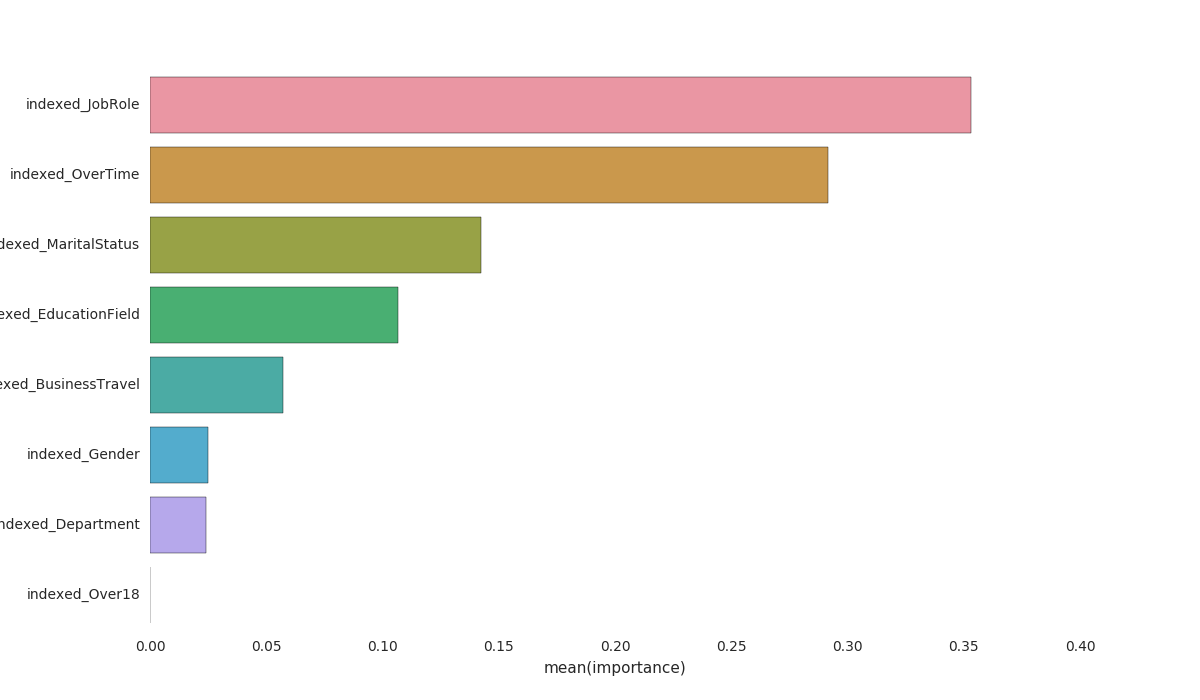

In [36]:
# SOMETHING LIKE THE FOLLOWING SHOULD WORK...
import seaborn as sns
import matplotlib.pyplot as plt

f, ax = plt.subplots(figsize=(12, 7))
sns.set(style="darkgrid")
sns.barplot(y="features",x="importance",data=df_importance)

display(f.figure)

## Above and Beyond

Completing the above tasks will earn you up to 64 of the 80 points available for this assignment. Completing one (and only one) of the following tasks will earn up to 16 additional points. Please review the details of scaling "Above and Beyond" points from the previous homework assignment to understand how these points will be used in the calculation of your final point score in this course.

1. Use the cross-validation approach (https://spark.apache.org/docs/latest/ml-tuning.html#cross-validation) to train, test and evaluate the Random Forest model on the IBM dataset, instead of using a train-test split. Describe, in detail, the advantages of using this approach, how the results compare to the above analysis, and how much longer it takes to conduct this analysis.
2. Repeat the analysis for Steps 4-12 using Gradient-Boosted Trees (https://spark.apache.org/docs/latest/ml-classification-regression.html#gradient-boosted-tree-classifier) and compare the results to Random Forest. Describe, in detail, how the classification results differ. The majority of your work should go into exploring the differences in the results.

### Task 2 - Gradient Boosted Trees

* <a href =https://community.cloud.databricks.com/?o=4609019411349203#notebook/1902500948198647/command/714432049486577>Cmd40</a>: Preparing transformer and pipeline
* <a href =https://community.cloud.databricks.com/?o=4609019411349203#notebook/1902500948198647/command/714432049486579>Cmd41-42</a>: Implementing GBT on test data
* <a href =https://community.cloud.databricks.com/?o=4609019411349203#notebook/1902500948198647/command/714432049486581>Cmd43</a>: Accuracy of GBT
* <a href =https://community.cloud.databricks.com/?o=4609019411349203#notebook/1902500948198647/command/714432049486582>Cmd44</a>: Feature importance table
* <a href =https://community.cloud.databricks.com/?o=4609019411349203#notebook/1902500948198647/command/714432049486583>Cmd45</a>: SNS bar plot of feature importances

The results for Random Forest classification to Gradient-Boosted Trees classification indicate marginal differences in performance, with Random Forest outperfroming Gradient-Boosted Trees by 1% (<a href=https://community.cloud.databricks.com/?o=4609019411349203#notebook/1902500948198647/command/1902500948198679>Cmd 31</a> vs <a href =https://community.cloud.databricks.com/?o=4609019411349203#notebook/1902500948198647/command/714432049486581>Cmd43</a>)

In distinct differences with the 2 methods for the IBM Test dataset seem to lie on which features are considered important by the classifier. Job Role and Over18 take similar levels of importance(most important and not important respectively) for both methods, while, based on <a href =https://community.cloud.databricks.com/?o=4609019411349203#notebook/1902500948198647/command/714432049486584>Cmd46</a>, the overtime categorical variable is given less importance in gradient-boosted trees, giving more importance to business travel frequency, with educational field also gaining a boost in importance compared to the random forest classifier. Due to this, both business travel frequency and educational field have a stronger and close to equal effect in classification for Gradient-boosted trees.

In terms of differences in classification, out of the 312 rows in the IBM test data, only 19 rows do not have consensus between random forest and gradient-boosted trees in terms of predicted tags

In [39]:
from pyspark.ml.classification import GBTClassifier

In [40]:
gbt = GBTClassifier(labelCol='indexed_Attrition', featuresCol='catfeatures', maxIter=10)
allstages_gbt = indexers + [vector, vectorindex, gbt, unindexer]
gbt_pipeline = Pipeline(stages=allstages_gbt)

In [41]:
gbt_model = gbt_pipeline.fit(ibm_train)
gbt_predictions = gbt_model.transform(ibm_test)

In [42]:
# YOUR CODE GOES HERE
display(gbt_predictions.select('Attrition', 'predicted_Attrition'))

Attrition,predicted_Attrition
Yes,No
No,No
No,No
No,No
Yes,No
No,No
Yes,Yes
Yes,No
Yes,No
No,No


In [43]:
gbt_acc = evaluator.evaluate(gbt_predictions)
gbt_acc

Out[ 129 ]: 0.8557692307692307

In [44]:
gbt_importance = pd.DataFrame(data={'features': featurelist, 'importance': gbt_model.stages[-2].featureImportances})
gbt_importance = gbt_importance.sort_values(by='importance', ascending=False)
gbt_importance

Out[ 130 ]: 
 features importance
4 indexed_JobRole 0.307414
0 indexed_BusinessTravel 0.197393
2 indexed_EducationField 0.197389
5 indexed_MaritalStatus 0.131542
7 indexed_OverTime 0.109686
3 indexed_Gender 0.046092
1 indexed_Department 0.010483
6 indexed_Over18 0.000000

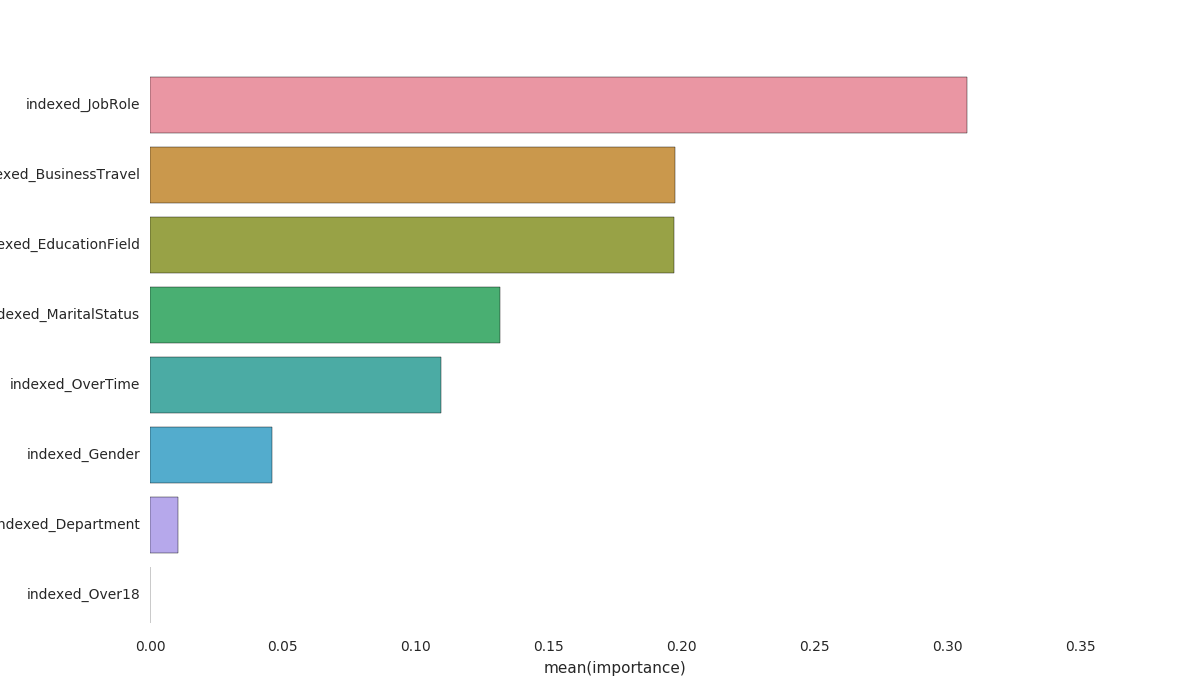

In [45]:
f, ax = plt.subplots(figsize=(12, 7))
sns.set(style="darkgrid")
sns.barplot(y="features",x="importance",data=gbt_importance)

display(f.figure)

In [46]:
combined = df_importance.set_index('features').join(gbt_importance.set_index('features'), lsuffix='_RandomForest', rsuffix='_GradientBoosted')
combined['Difference'] = combined.importance_RandomForest - combined.importance_GradientBoosted
combined.sort_values(by='Difference', ascending=False)

Out[ 132 ]: 
 importance_RandomForest importance_GradientBoosted \
features 
indexed_OverTime 0.291508 0.109686 
indexed_JobRole 0.353278 0.307414 
indexed_Department 0.024075 0.010483 
indexed_MaritalStatus 0.142393 0.131542 
indexed_Over18 0.000000 0.000000 
indexed_Gender 0.024739 0.046092 
indexed_EducationField 0.106801 0.197389 
indexed_BusinessTravel 0.057207 0.197393 

 Difference 
features 
indexed_OverTime 0.181822 
indexed_JobRole 0.045864 
indexed_Department 0.013592 
indexed_MaritalStatus 0.010850 
indexed_Over18 0.000000 
indexed_Gender -0.021354 
indexed_EducationField -0.090588 
indexed_BusinessTravel -0.140186

In [47]:
# YOUR CODE GOES HERE
rf_res = predictions.select('Attrition', 'predicted_Attrition').toPandas()
gbt_res = gbt_predictions.select('predicted_Attrition').toPandas()
comparison_labels = pd.DataFrame({'Attrition':rf_res.Attrition, 'RF_Attrition':rf_res.predicted_Attrition, 'GBT_Attrition': gbt_res.predicted_Attrition},\
                                 columns=['Attrition', 'RF_Attrition', 'GBT_Attrition'])
comparison_labels['consensus'] = comparison_labels.RF_Attrition == comparison_labels.GBT_Attrition
comparison_labels

Out[ 133 ]: 
 Attrition RF_Attrition GBT_Attrition consensus
0 Yes No No True
1 No No No True
2 No No No True
3 No No No True
4 Yes No No True
5 No No No True
6 Yes Yes Yes True
7 Yes No No True
8 Yes No No True
9 No No No True
10 No No No True
11 Yes No No True
12 No No No True
13 No No No True
14 Yes Yes No False
15 No No No True
16 No No No True
17 No No No True
18 No No No True
19 Yes Yes Yes True
20 Yes No No True
21 Yes No No True
22 No No No True
23 No No No True
24 No No No True
25 No Yes No False
26 No No No True
27 No No No True
28 No No No True
29 No No No True
.. ... ... ... ...
282 No No No True
283 Yes No No True
284 Yes No No True
285 Yes No Yes False
286 Yes No No True
287 Yes No No True
288 No No No True
289 No No No True
290 No No No True
291 No No No True
292 No No No True
293 No No No True
294 No No No True
295 No No No True
296 No No No True
297 No No No True
298 Yes No No True
299 No No No True
300 No No No True
301 No No No True
302 No No No True
303 No No No True
304 No No No True
305 No No No True
306 No No No True
307 No No No True
308 No No No True
309 No No No True
310 No No No True
311 No No No True

[312 rows x 4 columns]

In [48]:
comparison_labels[comparison_labels.consensus == False]

Out[ 134 ]: 
 Attrition RF_Attrition GBT_Attrition consensus
14 Yes Yes No False
25 No Yes No False
39 No No Yes False
48 Yes No Yes False
56 No No Yes False
75 Yes Yes No False
76 Yes No Yes False
95 Yes Yes No False
96 Yes Yes No False
107 Yes Yes No False
116 No No Yes False
128 Yes No Yes False
129 Yes No Yes False
153 Yes Yes No False
164 No No Yes False
212 No Yes No False
232 No Yes No False
240 Yes Yes No False
285 Yes No Yes False

## End of Homework 9